In [1]:
# Импортируем необходимые библиотеки
import pandas as pd
import numpy as np

# Загружаем xlsx файл
# Замените 'your_file.xlsx' на путь к вашему файлу
df = pd.read_excel(r"D:\дз\курсовая\Data2017 -2019_1.xlsx")

# Посмотрим первые несколько строк данных
print(df.head())

# Проверим информацию о данных
print(df.info())

           X          Y  produkt  date Agrotech  Soil    ГК   Sum    Ca    Mg  \
0  59.423807  30.038469      0.1  2018        K   АПд  2.31  8.38  7.12  1.26   
1  59.423821  30.038704      0.1  2018        K   АПд  2.31  8.38  7.12  1.26   
2  59.423848  30.039059      0.1  2018        K  АПдг  2.31  8.38  7.12  1.26   
3  59.423862  30.039295      0.1  2018        K  АПдг  2.31  8.38  7.12  1.26   
4  59.423868  30.039537      0.1  2018        K  АПдг  2.31  8.38  7.12  1.26   

   pH_KCL    P    K     N   Org  
0     5.4  327  188  0.31  0.89  
1     5.4  327  188  0.31  0.89  
2     5.4  327  188  0.31  0.89  
3     5.4  327  188  0.31  0.89  
4     5.4  327  188  0.31  0.89  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8182 entries, 0 to 8181
Data columns (total 15 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   X         8182 non-null   float64
 1   Y         8182 non-null   float64
 2   produkt   8182 non-null   float64
 3   da

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from catboost import CatBoostRegressor
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Функция для расчета MAPE
def calculate_mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# 1. Анализ выбросов
def analyze_outliers(df, numeric_columns, z_score_threshold=3):
    outliers_info = {}
    all_outliers_indices = set()
    
    print("\nАнализ выбросов для каждого признака:")
    for col in numeric_columns:
        z_scores = np.abs(stats.zscore(df[col]))
        outliers_mask = z_scores > z_score_threshold
        outliers_count = outliers_mask.sum()
        outliers_indices = df[outliers_mask].index
        
        outliers_info[col] = {
            'count': outliers_count,
            'percentage': (outliers_count / len(df)) * 100,
            'indices': outliers_indices
        }
        
        all_outliers_indices.update(outliers_indices)
        
        print(f"{col}: найдено {outliers_count} выбросов ({outliers_info[col]['percentage']:.2f}%)")
    
    print(f"\nВсего уникальных строк с выбросами: {len(all_outliers_indices)}")
    print(f"Процент строк с выбросами: {(len(all_outliers_indices) / len(df)) * 100:.2f}%")
    
    return list(all_outliers_indices), outliers_info

# 2. Подготовка данных
df['Soil'] = df['Soil'].fillna('Unknown')

# Определяем числовые признаки для анализа выбросов
numeric_features = ['ГК', 'Sum', 'Ca', 'Mg', 'pH_KCL', 'P', 'K', 'N', 'Org', 'produkt']
# Выводим количество нулевых значений продуктивности
print("Количество нулевых значений продуктивности:", (df['produkt'] == 0).sum())

# Удаляем строки с нулевой продуктивностью
df = df[df['produkt'] > 0]
print("Размер датасета после удаления нулевых значений:", len(df))
# Сохраняем информацию о фильтрации
print("\nСтатистика продуктивности до фильтрации:")
print(df['produkt'].describe())

df = df[df['produkt'] > 0]

print("\nСтатистика продуктивности после фильтрации:")
print(df['produkt'].describe())

# Анализируем выбросы
print("\nРазмер исходного датасета:", len(df))
outliers_indices, outliers_info = analyze_outliers(df, numeric_features, z_score_threshold=3)

# Спрашиваем пользователя об удалении выбросов
remove_outliers = True

if remove_outliers:
    df_clean = df.drop(outliers_indices)
    print(f"Размер датасета после удаления выбросов: {len(df_clean)}")
    print(f"Удалено строк: {len(df) - len(df_clean)}")
else:
    df_clean = df
    print("Выбросы оставлены в датасете")

# 3. Подготовка признаков
shuffle_index = np.random.permutation(len(df))
df_shuffled = df.iloc[shuffle_index].reset_index(drop=True)

features = ['Agrotech', 'Soil', 'ГК', 'Sum', 'Ca', 'Mg', 'pH_KCL', 'P', 'K', 'N', 'Org']
X = df_clean[features]
y = df_clean['produkt']

# Разделяем данные
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. Подбор гиперпараметров через GridSearchCV
param_grid = {
    'learning_rate': [0.05, 0.1],
    'depth': [4, 6],
    'iterations': [500]
}

cat_features = ['Agrotech', 'Soil']

# Базовая модель для GridSearchCV
base_model = CatBoostRegressor(
    cat_features=cat_features,
    random_seed=42,
        iterations=1000,
    depth=6,
    learning_rate=0.03,
    verbose=False

)

# GridSearchCV
grid_search = GridSearchCV(
    estimator=base_model,
    param_grid=param_grid,
    cv=3,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

print("\nНачало подбора параметров...")
# Обучаем модель с подбором параметров
grid_search.fit(X_train, y_train)

# Получаем лучшие параметры
print("\nЛучшие параметры:")
print(grid_search.best_params_)

# Используем лучшую модель
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# 5. Оценка результатов
def print_metrics(y_true, y_pred, model_name):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    mape = calculate_mape(y_true, y_pred)
    
    print(f'\nМетрики для {model_name}:')
    print(f'RMSE: {rmse:.4f}')
    print(f'R2 Score: {r2:.4f}')
    print(f'MAPE: {mape:.2f}%')

print_metrics(y_test, y_pred, "CatBoost (после оптимизации)")

# 6. Важность признаков
feature_importance = pd.DataFrame({
    'feature': features,
    'importance': best_model.feature_importances_
})
print("\nВажность признаков:")
print(feature_importance.sort_values(by='importance', ascending=False))


Количество нулевых значений продуктивности: 0
Размер датасета после удаления нулевых значений: 8182

Статистика продуктивности до фильтрации:
count    8182.000000
mean        3.416634
std         1.570037
min         0.100000
25%         2.300000
50%         3.700000
75%         4.500000
max        12.500000
Name: produkt, dtype: float64

Статистика продуктивности после фильтрации:
count    8182.000000
mean        3.416634
std         1.570037
min         0.100000
25%         2.300000
50%         3.700000
75%         4.500000
max        12.500000
Name: produkt, dtype: float64

Размер исходного датасета: 8182

Анализ выбросов для каждого признака:
ГК: найдено 0 выбросов (0.00%)
Sum: найдено 0 выбросов (0.00%)
Ca: найдено 0 выбросов (0.00%)
Mg: найдено 0 выбросов (0.00%)
pH_KCL: найдено 0 выбросов (0.00%)
P: найдено 0 выбросов (0.00%)
K: найдено 0 выбросов (0.00%)
N: найдено 0 выбросов (0.00%)
Org: найдено 0 выбросов (0.00%)
produkt: найдено 18 выбросов (0.22%)

Всего уникальных строк с 

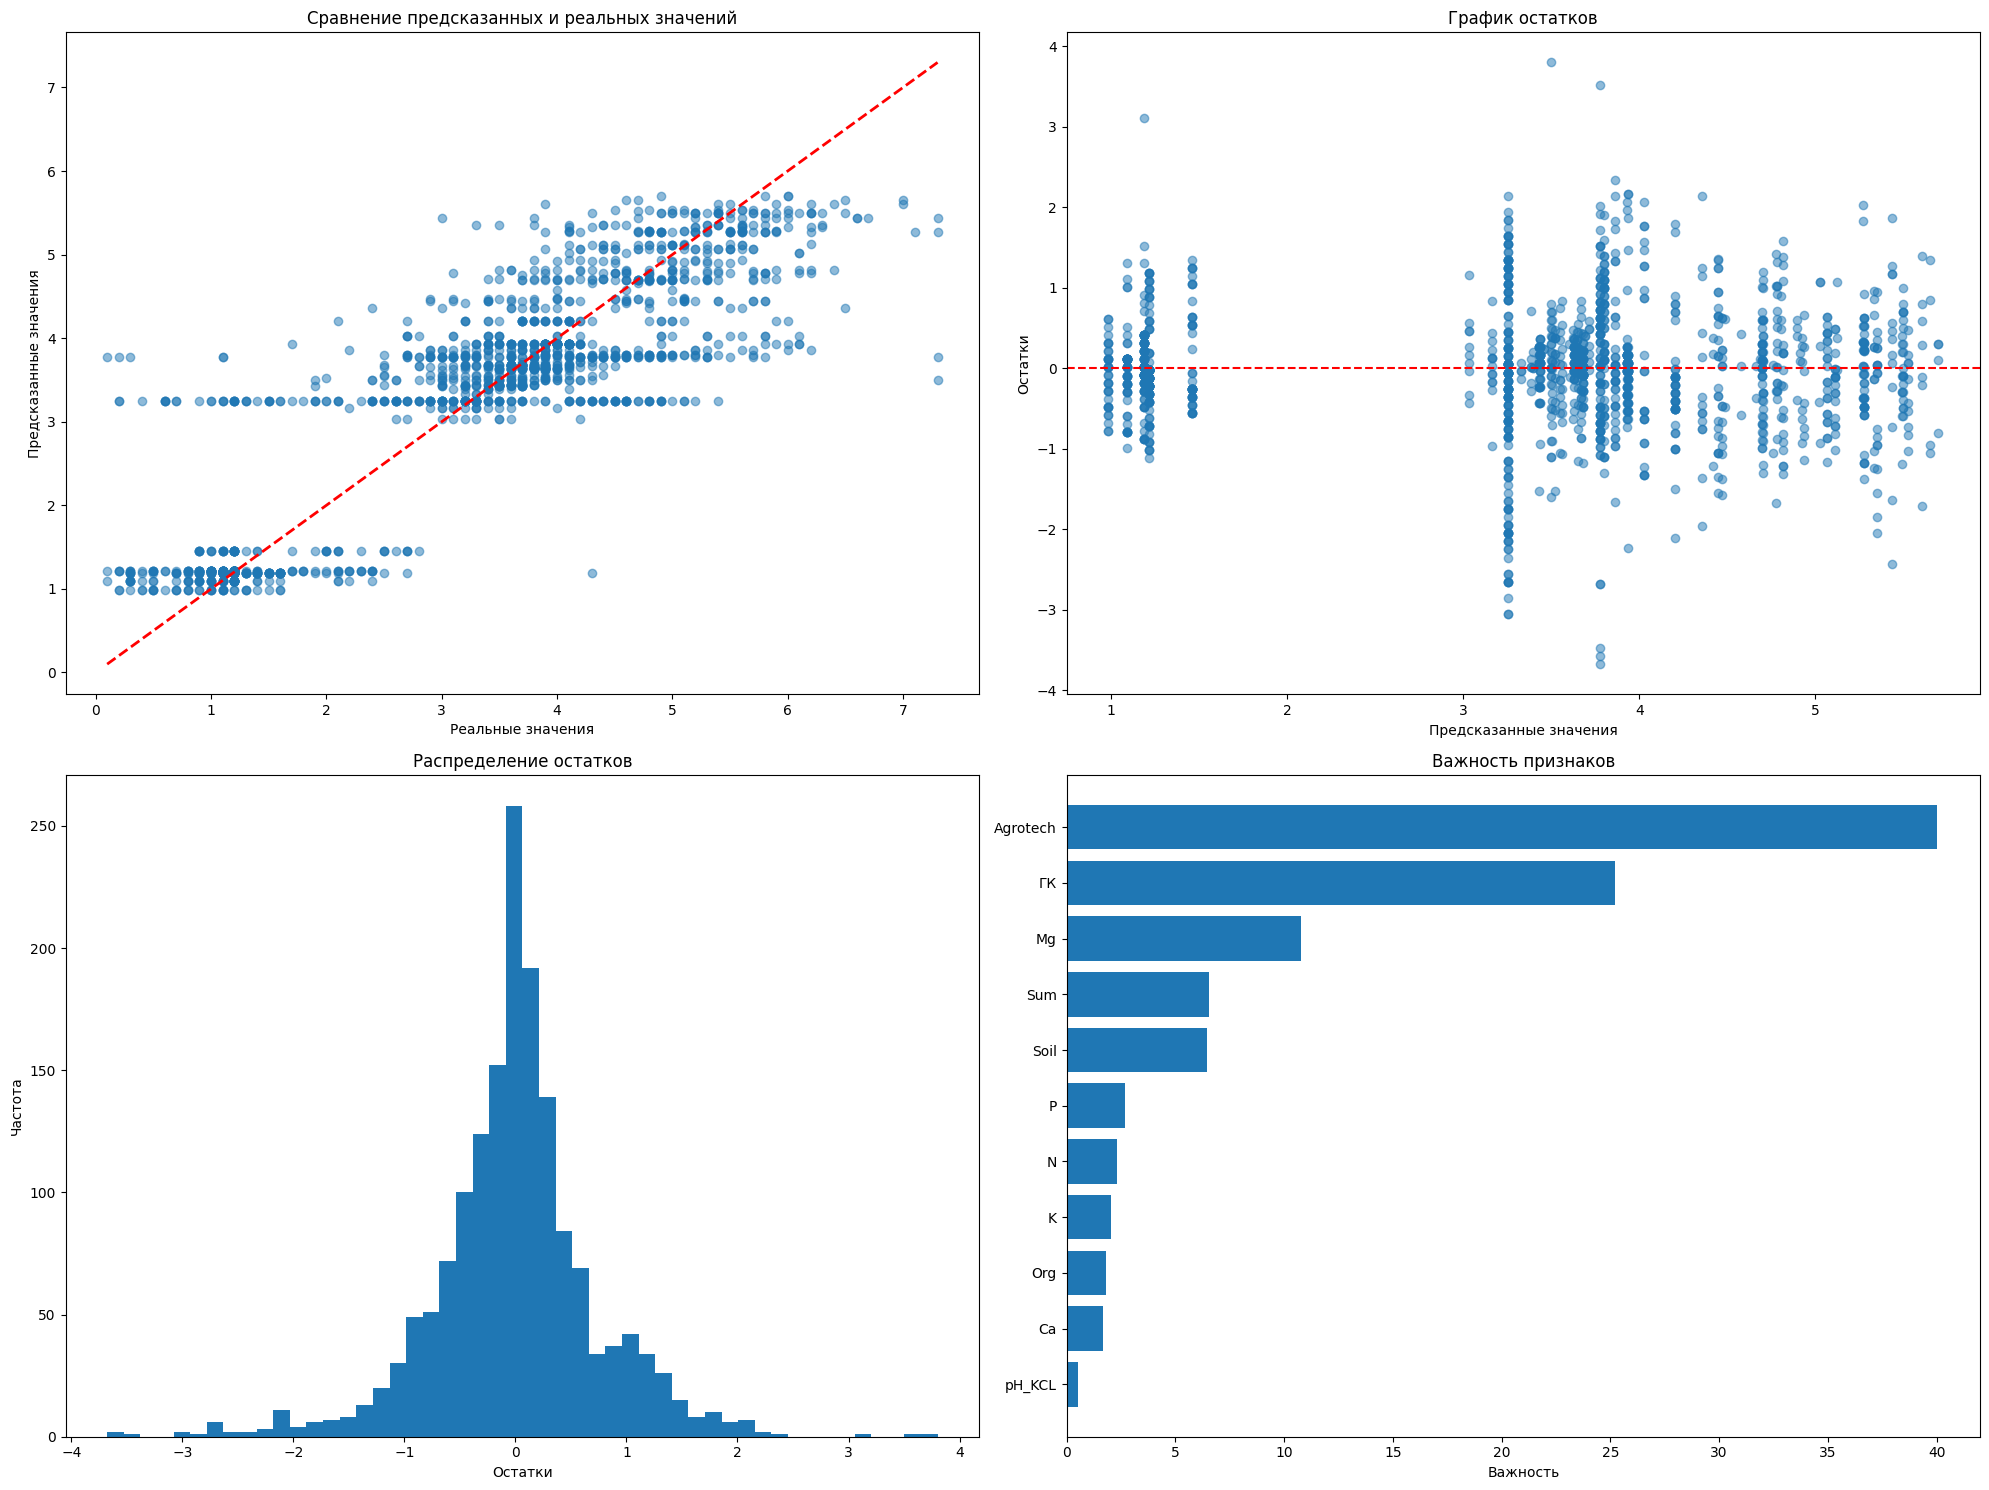

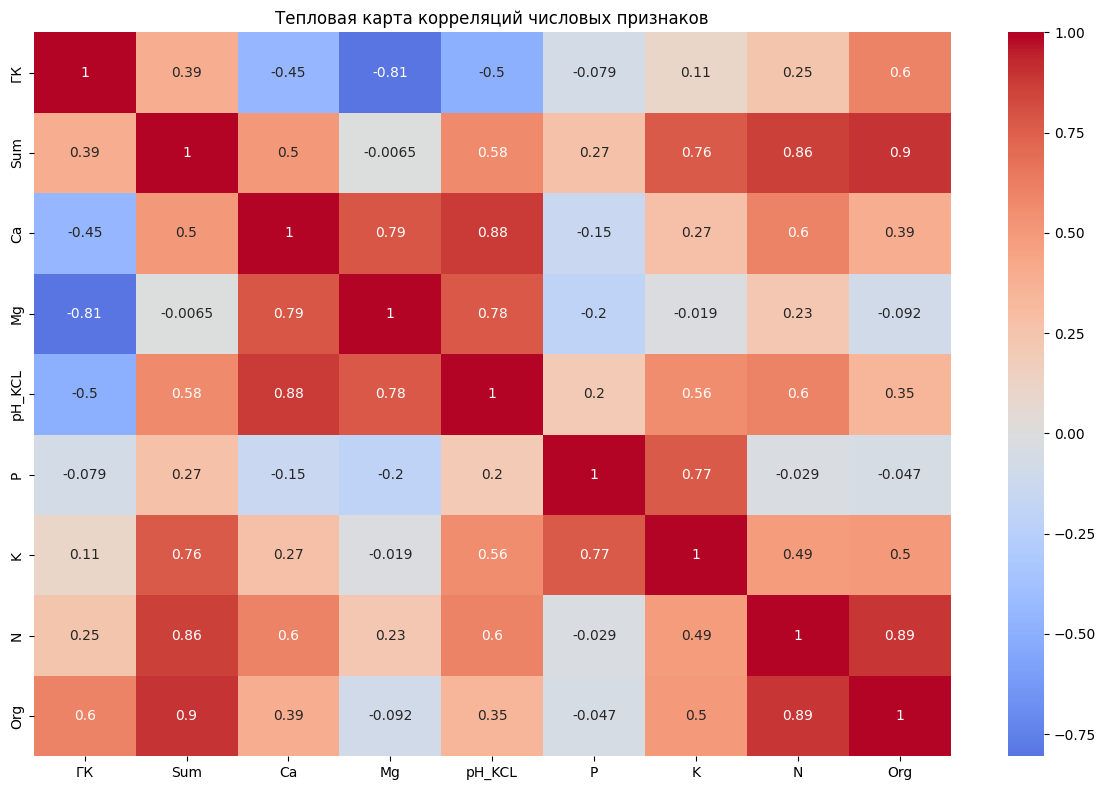

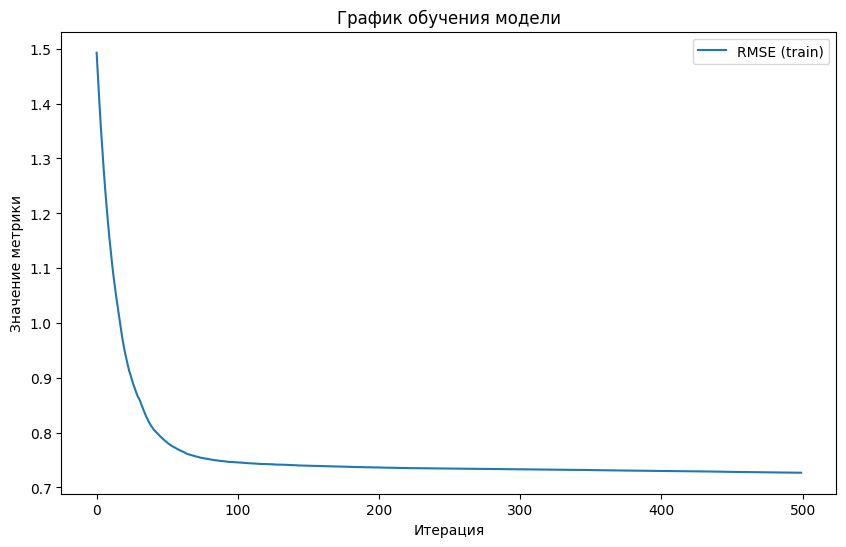


Параметры модели:
iterations: 500
learning_rate: 0.05
depth: 6
loss_function: RMSE
random_seed: 42
verbose: False
cat_features: ['Agrotech', 'Soil']

Статистика по остаткам:
Среднее остатков: -0.0105
Стандартное отклонение остатков: 0.7500
Минимум остатков: -3.6772
Максимум остатков: 3.8020

Статистика по предсказаниям:
Среднее абсолютное отклонение (MAE): 0.5189
Медианное абсолютное отклонение: 0.3333

Процентили остатков:
1-й процентиль: -2.2523
5-й процентиль: -1.1702
25-й процентиль: -0.3578
50-й процентиль: 0.0010
75-й процентиль: 0.3150
95-й процентиль: 1.2477
99-й процентиль: 1.8900

Метрики по категориальным группам:

Метрики для разных значений Agrotech:

X_1:
RMSE: 0.7468
R2: 0.0723
MAPE: 14.21%
Количество наблюдений: 94

K:
RMSE: 0.4671
R2: 0.8653
MAPE: 20.56%
Количество наблюдений: 408

TZ:
RMSE: 0.9659
R2: 0.4082
MAPE: 41.79%
Количество наблюдений: 617

VI:
RMSE: 0.6263
R2: 0.8678
MAPE: 30.58%
Количество наблюдений: 514

Метрики для разных значений Soil:

АПдг:
RMSE: 0.74

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score

def visualize_model_results(model, X_train, X_test, y_train, y_test, y_pred, features):
    # Создаем фигуру большого размера
    plt.figure(figsize=(20, 15))
    
    # 1. График предсказанных vs реальных значений
    plt.subplot(2, 2, 1)
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.xlabel('Реальные значения')
    plt.ylabel('Предсказанные значения')
    plt.title('Сравнение предсказанных и реальных значений')

    # 2. График остатков
    plt.subplot(2, 2, 2)
    residuals = y_test - y_pred
    plt.scatter(y_pred, residuals, alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('Предсказанные значения')
    plt.ylabel('Остатки')
    plt.title('График остатков')

    # 3. Гистограмма остатков
    plt.subplot(2, 2, 3)
    plt.hist(residuals, bins=50)
    plt.xlabel('Остатки')
    plt.ylabel('Частота')
    plt.title('Распределение остатков')

    # 4. График важности признаков
    importance = pd.DataFrame({
        'feature': features,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=True)
    
    plt.subplot(2, 2, 4)
    plt.barh(importance['feature'], importance['importance'])
    plt.xlabel('Важность')
    plt.title('Важность признаков')

    plt.tight_layout()
    plt.show()

    # 5. Тепловая карта корреляций
    plt.figure(figsize=(12, 8))
    numeric_cols = X_train.select_dtypes(include=[np.number]).columns
    correlation_matrix = X_train[numeric_cols].corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
    plt.title('Тепловая карта корреляций числовых признаков')
    plt.tight_layout()
    plt.show()

    # 6. График обучения модели (если доступен)
    if hasattr(model, 'evals_result_'):
        plt.figure(figsize=(10, 6))
        # Получаем все метрики, доступные в результатах
        eval_metrics = model.evals_result_['learn'].keys()
        for metric in eval_metrics:
            plt.plot(model.evals_result_['learn'][metric], 
                    label=f'{metric} (train)')
            if 'test' in model.evals_result_:
                plt.plot(model.evals_result_['test'][metric], 
                        label=f'{metric} (test)')
        plt.xlabel('Итерация')
        plt.ylabel('Значение метрики')
        plt.title('График обучения модели')
        plt.legend()
        plt.show()

    # Вывод параметров модели
    print("\nПараметры модели:")
    for param_name, param_value in model.get_params().items():
        print(f"{param_name}: {param_value}")

    # Статистика по остаткам
    print("\nСтатистика по остаткам:")
    print(f"Среднее остатков: {np.mean(residuals):.4f}")
    print(f"Стандартное отклонение остатков: {np.std(residuals):.4f}")
    print(f"Минимум остатков: {np.min(residuals):.4f}")
    print(f"Максимум остатков: {np.max(residuals):.4f}")

    # Дополнительная статистика по предсказаниям
    print("\nСтатистика по предсказаниям:")
    print(f"Среднее абсолютное отклонение (MAE): {np.mean(np.abs(residuals)):.4f}")
    print(f"Медианное абсолютное отклонение: {np.median(np.abs(residuals)):.4f}")
    
    # Процентили остатков
    percentiles = [1, 5, 25, 50, 75, 95, 99]
    print("\nПроцентили остатков:")
    for p in percentiles:
        print(f"{p}-й процентиль: {np.percentile(residuals, p):.4f}")

# Использование функции
visualize_model_results(
    model=best_model,
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
    y_pred=y_pred,
    features=features
)

# Дополнительно выводим метрики по категориальным группам
print("\nМетрики по категориальным группам:")
for cat_feature in ['Agrotech', 'Soil']:
    print(f"\nМетрики для разных значений {cat_feature}:")
    for unique_val in X_test[cat_feature].unique():
        mask = X_test[cat_feature] == unique_val
        if mask.sum() > 0:
            group_rmse = np.sqrt(mean_squared_error(y_test[mask], y_pred[mask]))
            group_r2 = r2_score(y_test[mask], y_pred[mask])
            group_mape = calculate_mape(y_test[mask], y_pred[mask])
            print(f"\n{unique_val}:")
            print(f"RMSE: {group_rmse:.4f}")
            print(f"R2: {group_r2:.4f}")
            print(f"MAPE: {group_mape:.2f}%")
            print(f"Количество наблюдений: {mask.sum()}")

# Сохранение модели
best_model.save_model('catboost_model.cbm')
print("\nМодель сохранена в файл 'catboost_model.cbm'")


In [4]:
import os
# Добавляем путь к Graphviz в системные переменные
os.environ["PATH"] += os.pathsep + r"C:\Program Files\Graphviz\bin"

def visualize_trees(model, features, max_trees=3):
    """
    Визуализация первых нескольких деревьев решений из модели CatBoost
    """
    try:
        import graphviz
        
        # Проверяем доступность dot
        try:
            from subprocess import run, PIPE
            result = run(['dot', '-V'], stdout=PIPE, stderr=PIPE)
            print("Graphviz version:", result.stderr.decode())
        except Exception as e:
            print("Ошибка при проверке версии Graphviz:", str(e))
            
        print(f"\nВизуализация первых {max_trees} деревьев")
        
        # Создаем директорию для сохранения деревьев
        if not os.path.exists('tree_visualizations'):
            os.makedirs('tree_visualizations')
        
        # Явно указываем путь к dot
        graphviz.backend.executables = {'dot': r'C:\Program Files\Graphviz\bin\dot.exe'}
        
        # Визуализируем каждое дерево
        for tree_idx in range(min(max_trees, model.tree_count_)):
            try:
                tree_graph = model.plot_tree(tree_idx)
                
                # Сохраняем дерево с явным указанием пути к dot
                output_file = f'tree_visualizations/tree_{tree_idx}'
                tree_graph.render(filename=output_file, 
                                format='png',
                                cleanup=True,
                                engine='dot')
                print(f"Дерево {tree_idx} сохранено в {output_file}.png")
                
            except Exception as e:
                print(f"Ошибка при сохранении дерева {tree_idx}: {str(e)}")
        
        # Остальная часть функции остается без изменений...
        
    except Exception as e:
        print(f"Ошибка при визуализации деревьев: {str(e)}")

# Использование функции
visualize_trees(best_model, features, max_trees=3)


Graphviz version: dot - graphviz version 12.2.1 (20241206.2353)


Визуализация первых 3 деревьев
Дерево 0 сохранено в tree_visualizations/tree_0.png
Дерево 1 сохранено в tree_visualizations/tree_1.png
Дерево 2 сохранено в tree_visualizations/tree_2.png



Обучение модели CatBoost...
CatBoost результаты:
RMSE: 0.7535
R2: 0.7642
MAPE: 31.31%

Обучение модели XGBoost...
XGBoost результаты:
RMSE: 0.7497
R2: 0.7666
MAPE: 31.19%

Обучение модели LightGBM...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000401 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 82
[LightGBM] [Info] Number of data points in the train set: 6531, number of used features: 11
[LightGBM] [Info] Start training from score 3.416674
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] 

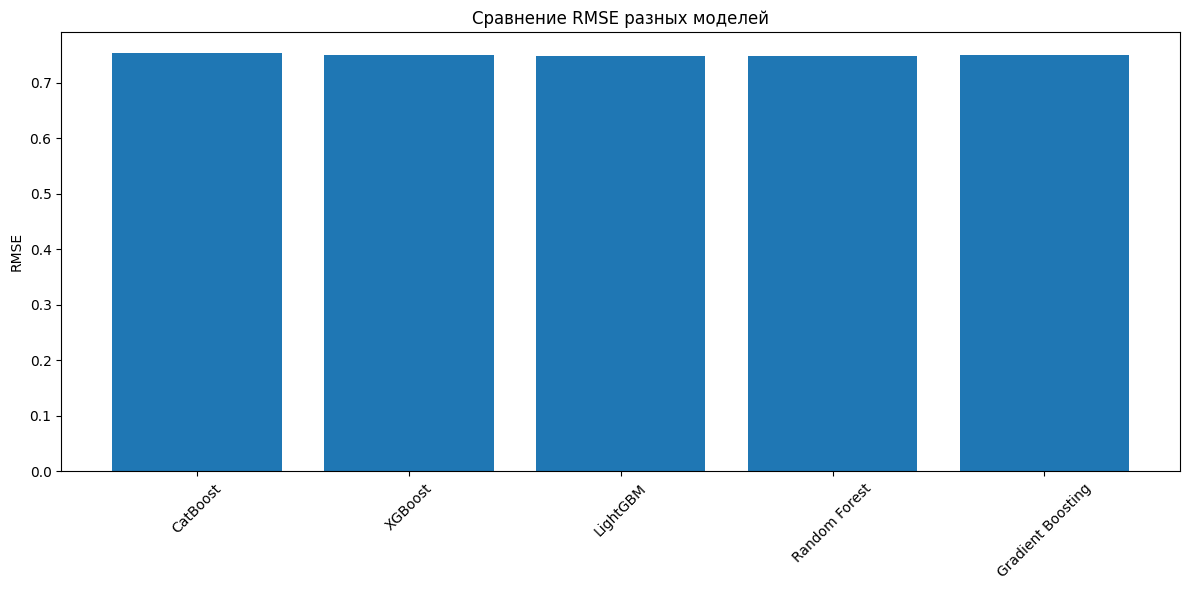

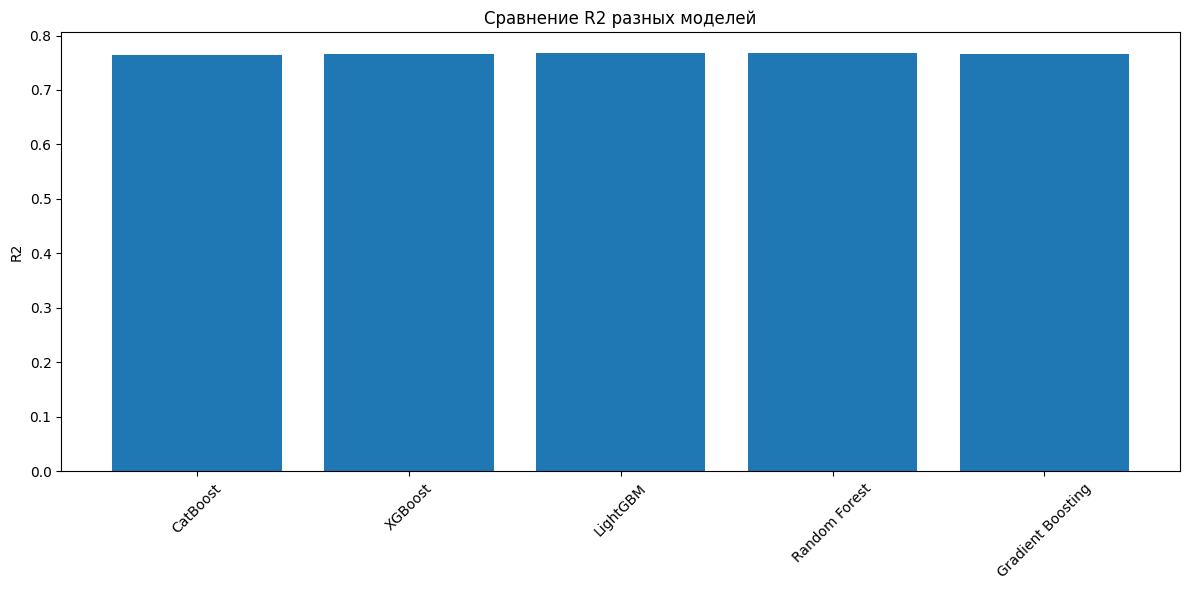


Сводная таблица результатов:
                       RMSE        R2       MAPE
CatBoost           0.753495  0.764226  31.305141
XGBoost            0.749670  0.766614  31.186627
LightGBM           0.748340  0.767441  31.177163
Random Forest      0.749088  0.766976  31.213115
Gradient Boosting  0.750208  0.766278  31.200033


In [5]:

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
import numpy as np

# Словарь для хранения результатов
results = {}

# 1. CatBoost
catboost_model = CatBoostRegressor(
    cat_features=cat_features,
    iterations=2000,
    depth=8,
    learning_rate=0.03,
    verbose=False,
    random_seed=42
)

# 2. XGBoost
xgb_model = XGBRegressor(
    n_estimators=2000,
    max_depth=8,
    learning_rate=0.03,
    random_state=42,
    n_jobs=-1
)

# 3. LightGBM
lgb_model = LGBMRegressor(
    n_estimators=2000,
    max_depth=8,
    learning_rate=0.03,
    random_state=42,
    n_jobs=-1
)

# 4. Random Forest
rf_model = RandomForestRegressor(
    n_estimators=500,
    max_depth=8,
    random_state=42,
    n_jobs=-1
)

# 5. Gradient Boosting
gb_model = GradientBoostingRegressor(
    n_estimators=500,
    max_depth=8,
    learning_rate=0.03,
    random_state=42
)

# Словарь моделей
models = {
    'CatBoost': catboost_model,
    'XGBoost': xgb_model,
    'LightGBM': lgb_model,
    'Random Forest': rf_model,
    'Gradient Boosting': gb_model
}

# Подготовка категориальных признаков для моделей кроме CatBoost
from sklearn.preprocessing import LabelEncoder

# Создаем копию данных
X_train_encoded = X_train.copy()
X_test_encoded = X_test.copy()

# Кодируем категориальные признаки
label_encoders = {}
for feature in cat_features:
    le = LabelEncoder()
    X_train_encoded[feature] = le.fit_transform(X_train[feature])
    X_test_encoded[feature] = le.transform(X_test[feature])
    label_encoders[feature] = le

# Обучение и оценка моделей
for name, model in models.items():
    print(f"\nОбучение модели {name}...")
    
    # Используем правильный набор данных
    if name == 'CatBoost':
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
    else:
        model.fit(X_train_encoded, y_train)
        y_pred = model.predict(X_test_encoded)
    
    # Считаем метрики
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    mape = calculate_mape(y_test, y_pred)
    
    results[name] = {
        'RMSE': rmse,
        'R2': r2,
        'MAPE': mape
    }
    
    print(f"{name} результаты:")
    print(f"RMSE: {rmse:.4f}")
    print(f"R2: {r2:.4f}")
    print(f"MAPE: {mape:.2f}%")

# Визуализация результатов
import matplotlib.pyplot as plt

# График сравнения RMSE
plt.figure(figsize=(12, 6))
plt.bar([name for name in results.keys()], 
        [results[name]['RMSE'] for name in results.keys()])
plt.title('Сравнение RMSE разных моделей')
plt.xticks(rotation=45)
plt.ylabel('RMSE')
plt.tight_layout()
plt.show()

# График сравнения R2
plt.figure(figsize=(12, 6))
plt.bar([name for name in results.keys()], 
        [results[name]['R2'] for name in results.keys()])
plt.title('Сравнение R2 разных моделей')
plt.xticks(rotation=45)
plt.ylabel('R2')
plt.tight_layout()
plt.show()

# Создаем DataFrame с результатами
results_df = pd.DataFrame.from_dict(results, orient='index')
print("\nСводная таблица результатов:")
print(results_df)

# Сохраняем результаты
results_df.to_csv('model_comparison_results.csv')


In [6]:
# Визуализация первого дерева
tree_graph = best_model.plot_tree(
    tree_index=0,
    pool=None
)
tree_graph.render(filename='first_tree', 
                 format='png',
                 cleanup=True)

TypeError: CatBoost.plot_tree() got an unexpected keyword argument 'tree_index'